In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np

from stats import *
from utils import *
import visual as vi
from Inlier_Thresholder import Inlier_Thresholder
import scipy.io as spi
from time import time
import os
import seaborn as sns
from itertools import chain


# Initialize the paths to the files and variables containing the data

- **names**    contains the names of the files

- **mat_data**    dictionary with keys= file names ; values = files

In [2]:
directory = 'C:/Users/carlo/IACV PROJECT/adelH'

# List all files in the directory
files = os.listdir(directory)

# Filter out only the .mat files
names = [file for file in files if file.endswith('.mat')]

# Load each .mat file
mat_data = {}
for file in names:
    file_path = os.path.join(directory, file)
    mat_data[file] = spi.loadmat(file_path)


In [3]:
# input parameter, how many files to analyse
number_of_data_to_analyse=len(names)



silhouette_scores = [[] for i in range(number_of_data_to_analyse)]
silhouette_avgs = [[] for i in range(number_of_data_to_analyse)]
labels_array = [[] for i in range(number_of_data_to_analyse)]
residuals = []
values_array = [[] for i in range(number_of_data_to_analyse)]
thresholds = [[] for i in range(number_of_data_to_analyse)]




for i in range(number_of_data_to_analyse):
    data=mat_data[names[i]]
    res=compute_inliers_residual_curve(data)
    residuals.append(res)

    for j in range(len(res)):
        anomaly_detector=Inlier_Thresholder(res[j])

        labels, threshold=anomaly_detector.use_best_method(verbose=False)  # use best method among the statistical ones, best according to silhouette
        
        if len(np.unique(labels))!=1:
            thresholds[i].append(threshold)
            labels_array[i].append(labels)
            silhouette_scr, silhouette_avg, values = silhouette_score_and_average(res[j], labels)
            silhouette_scores[i].append(silhouette_scr)
            silhouette_avgs[i].append(silhouette_avg)
            values_array[i].append(values)

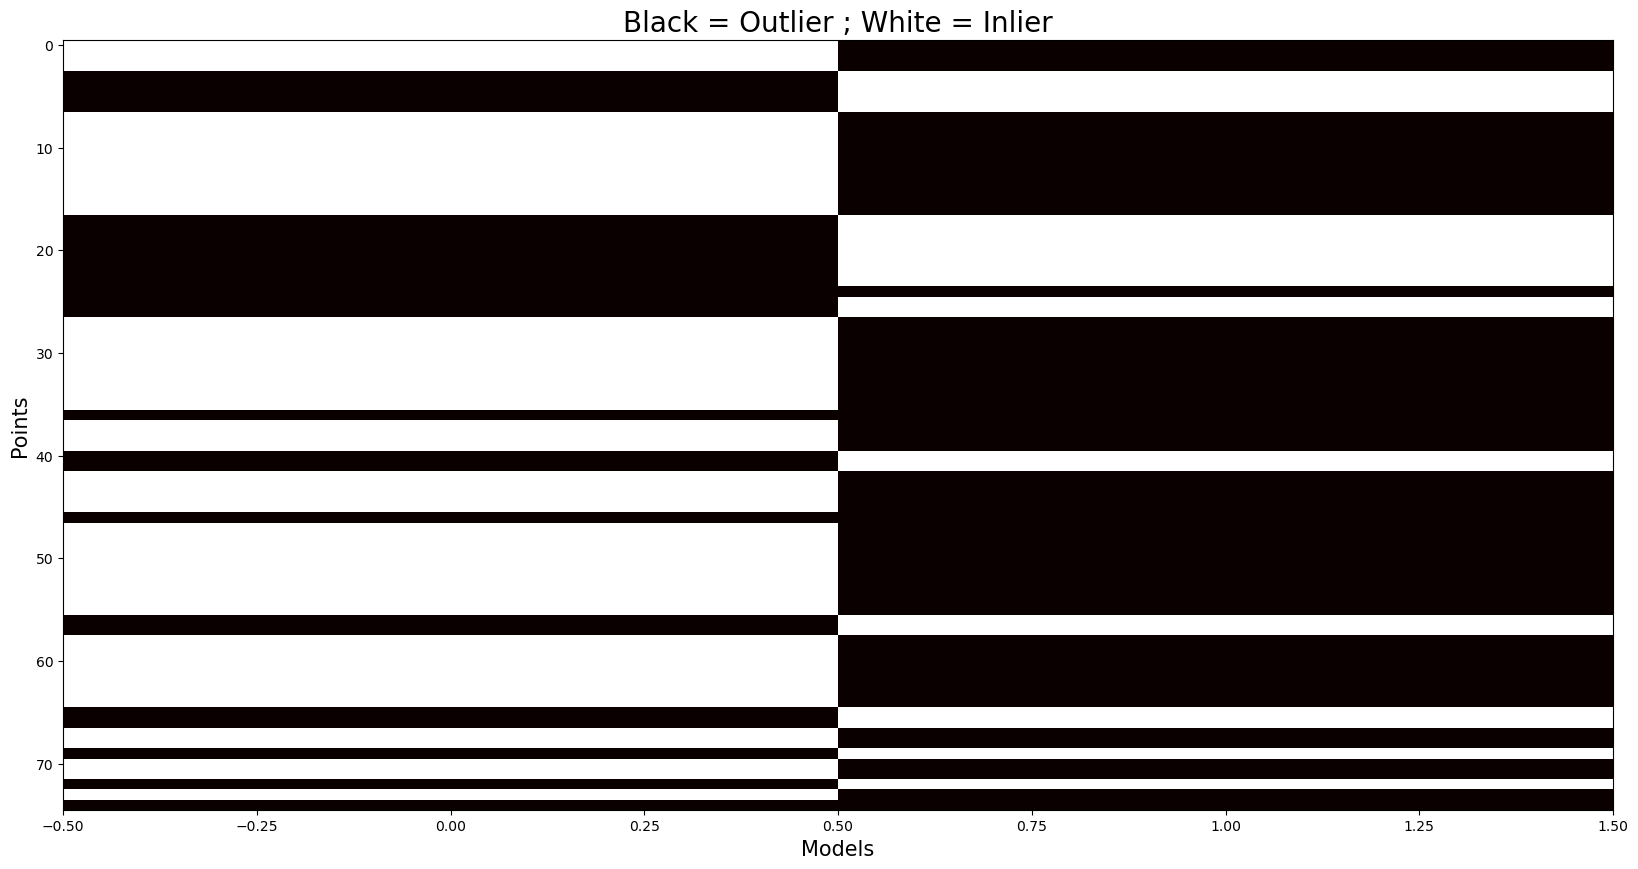

In [10]:
data=mat_data[names[0]]

res_matrix=build_residual_matrix(data,verbose=False)

def soft_clustering_assignment(residual_matrix , thresholds):
    assert residual_matrix.shape[1]==len(thresholds), "number of models in residual matrix different from number of models from threhsolds"
    soft_clustering_assignment=np.zeros(res_matrix.shape)
    
    for i in range(len(thresholds)):
        inlier_indexes=np.where(residual_matrix[:,i]<thresholds[i])
        soft_clustering_assignment[inlier_indexes,i]+=1
        
    return soft_clustering_assignment
    
soft_clustering=soft_clustering_assignment(res_matrix,thresholds[0])

plot_residual_matrix(soft_clustering,show_bar=False)

# Partition Matrix computation

It is a sort of soft clustering assignment. Element i,j is a sort of probability of point i belonging to cluster j.
The fuzzifier is a parameter controlling the "softness", as it approaches to 1, the clustering gets hard (element i,j either 0 or 1), experimentally a value of fuzzifier=2 gives good results.


In [96]:

def row_compuation(row, fuzzifier=2):
    
    new_row=np.zeros(len(row))
    
    for i in range(len(row)):
        for j in range(len(row)):
            new_row[i]+=(row[i]/row[j])**(2/(fuzzifier-1))
            
        new_row[i]=new_row[i]**(-1)
    return new_row

#row_compuation(res_matrix[0]), res_matrix[0]

def build_partition_matrix(residual_matrix):
    
    partition_matrix=np.zeros(residual_matrix.shape)
    
    for i in range(residual_matrix.shape[0]):
        partition_matrix[i,:]=row_compuation(residual_matrix[i,:])
        
    return partition_matrix


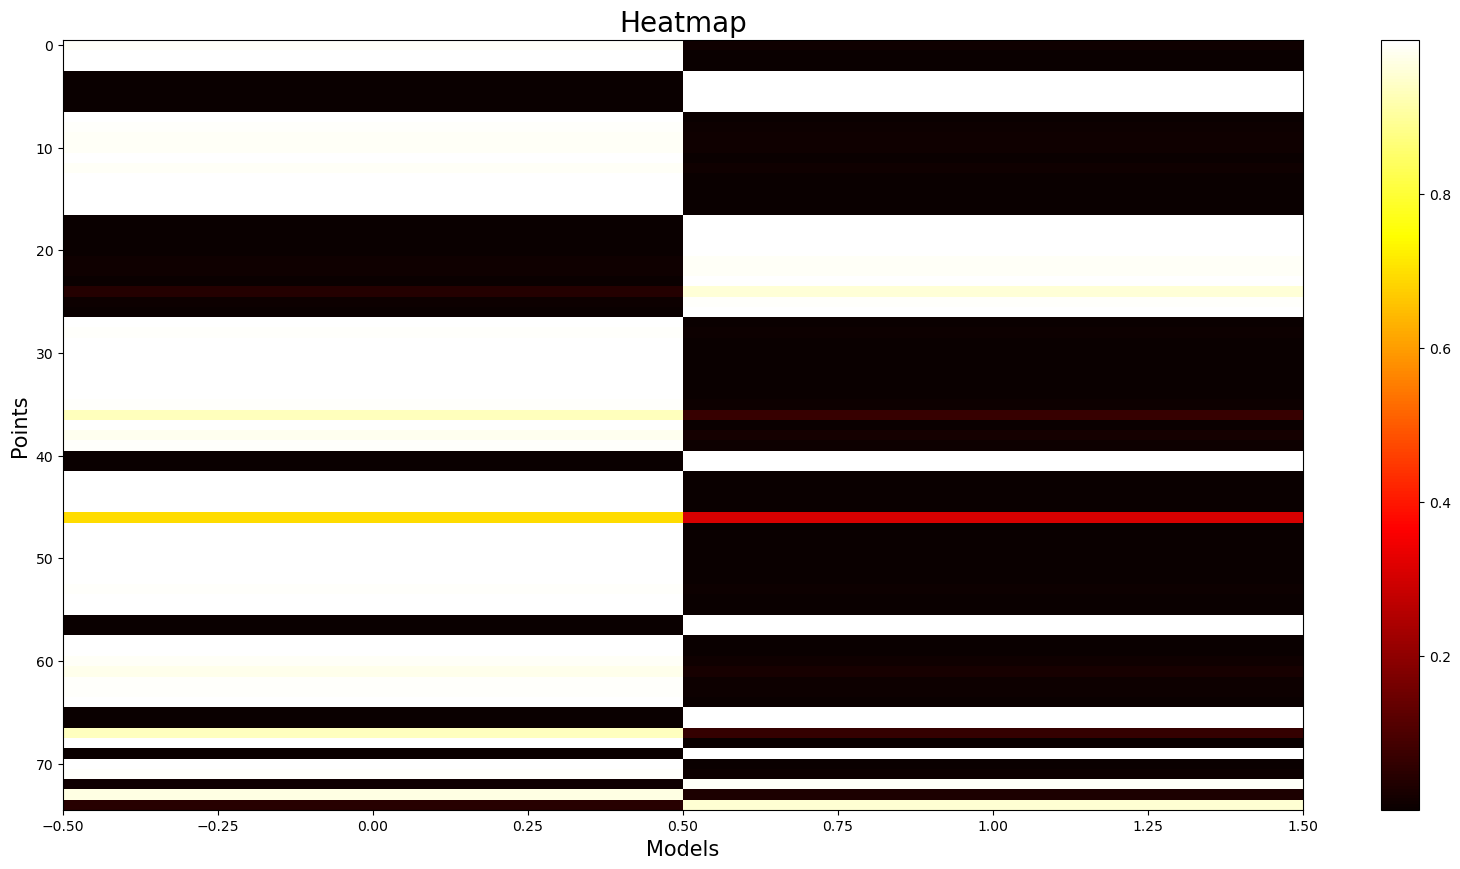

In [20]:
partition_matrix=build_partition_matrix(res_matrix)
plot_residual_matrix(partition_matrix)

In [101]:
#A fuzzy extension of the silhouette width criterion
#for cluster analysis
#R.J.G.B. Campello∗, E.R. Hruschka

########################################## Average within-cluster distance

def AWCD(residual_matrix , partition_matrix,fuzzifier=2):  # the lower the better
    """
    Compute the Avarage within-cluster distance

    Parameters:
    - residual_matrix
    - Partition_matrix
    - fuzzifier ----- The fuzzifier is a parameter controlling the "softness" of the clustering, as it approaches to 1, the clustering gets hard (element i,j either 0 or 1), experimentally a value of fuzzifier=2 gives good results. The same fuzzifier of the partition matrix muste be used
    
    Returns:
    - AWCD 
    """
    N,c=residual_matrix.shape[0],residual_matrix.shape[1]
    
    AWCD=0
    
    for i in range(c):
        numerator=0
        denominator=0
        
        for j in range(N):
            denominator+=partition_matrix[j,i]**fuzzifier
            numerator+=(residual_matrix[j,i]**2)*partition_matrix[j,i]**fuzzifier
            
        
        AWCD+=(1/c)* numerator/denominator
    return AWCD
    
    
    
#########################################  Fuzzy silhouette
def Fuzzy_silhouette(residual_matrix , partition_matrix ,alpha=1, fuzzifier=2): # the larger the better
    """
    Compute the Avarage within-cluster distance

    Parameters:
    - residual_matrix
    - Partition_matrix
    - fuzzifier ----- The fuzzifier is a parameter controlling the "softness" of the clustering, as it approaches to 1, the clustering gets hard (element i,j either 0 or 1), experimentally a value of fuzzifier=2 gives good results. The same fuzzifier of the partition matrix muste be used
    - alpha ----- alpha is a user defined parameter, by default alpha=1 is used
    
    Returns:
    - AWCD 
    """
    
    
    N=partition_matrix.shape[0]
    c=partition_matrix.shape[1]
    if c==1: return 1  # single model
    
    labels=np.zeros(N)

    for i in range(N):
        labels[i]=np.argmax(partition_matrix[i,:])
        
    # compute silhouette values using the hard clustering
        
    avarage_intracluster_distance=np.zeros(N)
    for i in range(N):
        l=labels[i].astype(int)
        avarage_intracluster_distance[i]=np.mean(abs(residual_matrix[i,l]-residual_matrix[np.where(labels==l),l]))
        
    
        
    avarage_intercluster_distance=np.zeros(partition_matrix.shape)+np.inf
    
    for i in range(N):
        l=labels[i]
        for j in range(c):
            if j!=l: avarage_intercluster_distance[i,j]=np.mean(abs(residual_matrix[i,j]-residual_matrix[np.where(labels==j),j]))
                
                
    si=np.zeros(N)
    for i in range(N):
        a=avarage_intracluster_distance[i]
        b=np.min(avarage_intercluster_distance[i,:])
  
        si[i]=(b-a)/np.max(np.array([a,b]))
        

        
    
    P_mat=partition_matrix.copy()
    numerator=0
    denominator=0
    for i in range(N):
        mu_p_index=np.argmax(P_mat[i,:])
        mu_p=P_mat[i,mu_p_index]
        P_mat[i,mu_p_index]=-np.inf
        mu_q=np.max(P_mat[i,:])
        
        numerator+=((mu_p-mu_q)**alpha) *si[i]
        denominator+=((mu_p-mu_q)**alpha)
        

        
    FS=numerator/denominator
        
                
    return FS



In [102]:
AWCD(res_matrix,partition_matrix),Fuzzy_silhouette(res_matrix,partition_matrix)

(14.284021983065097, 0.9346158845328725)

Soft clustering for all the images

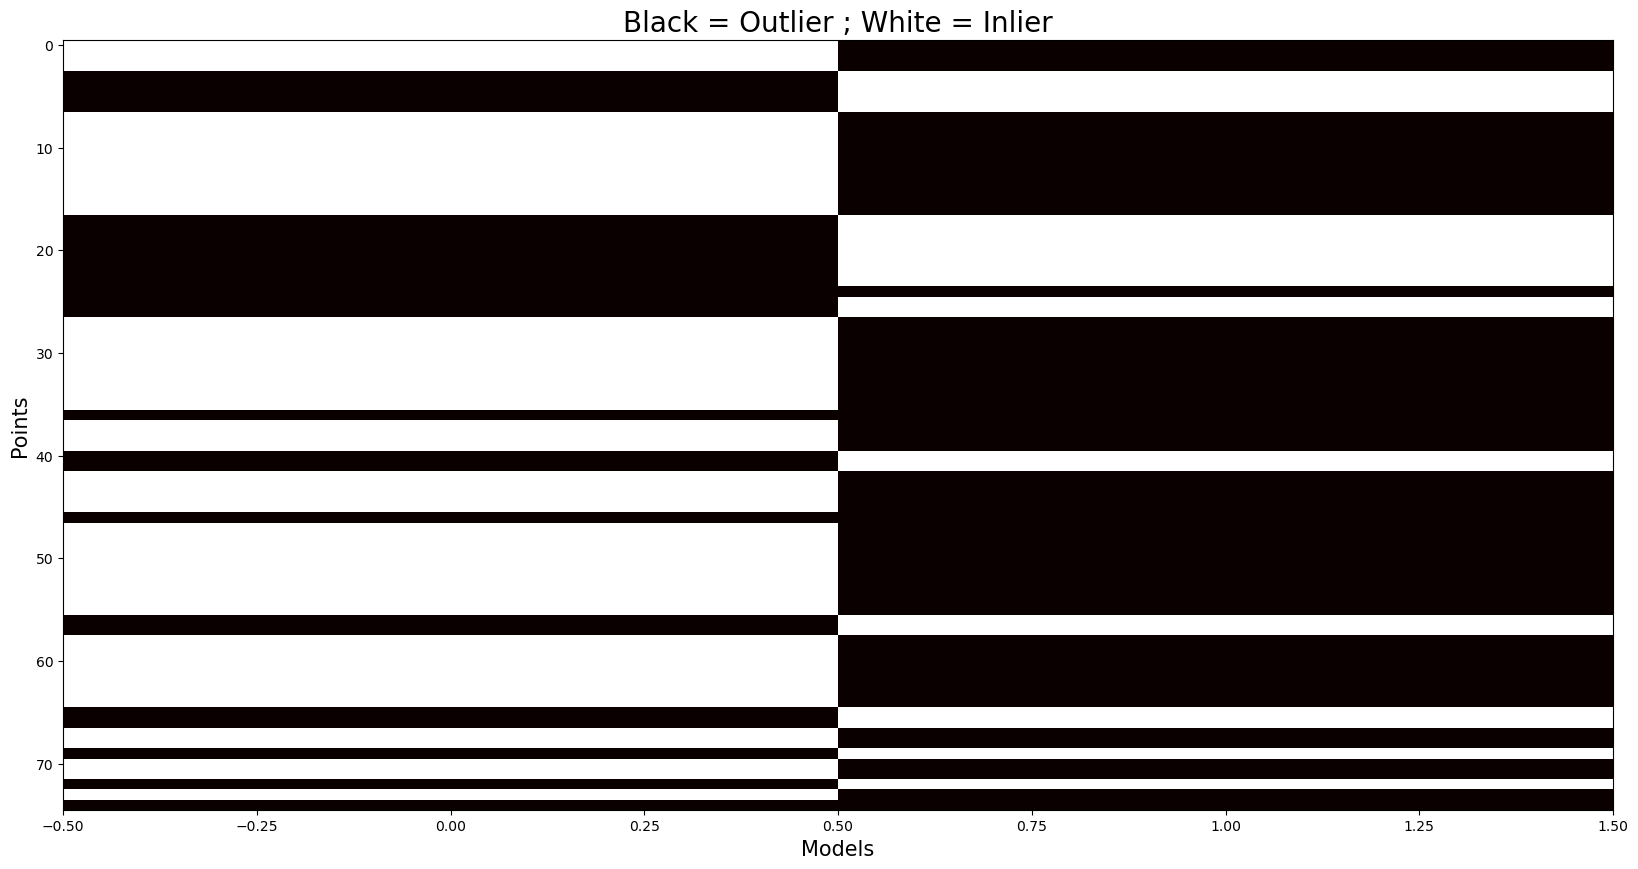

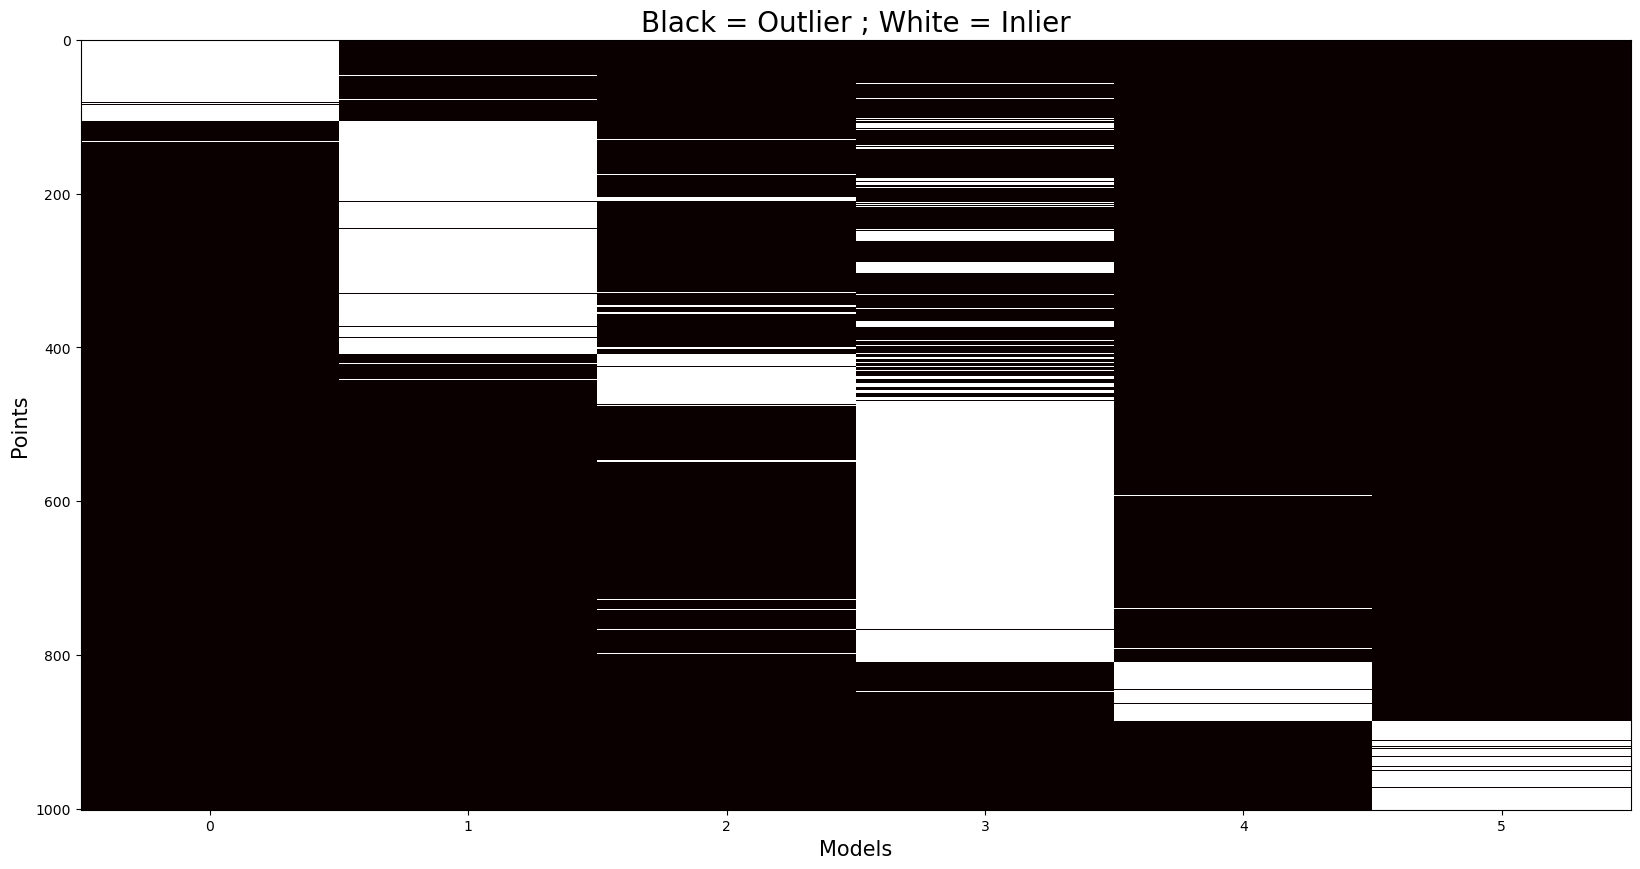

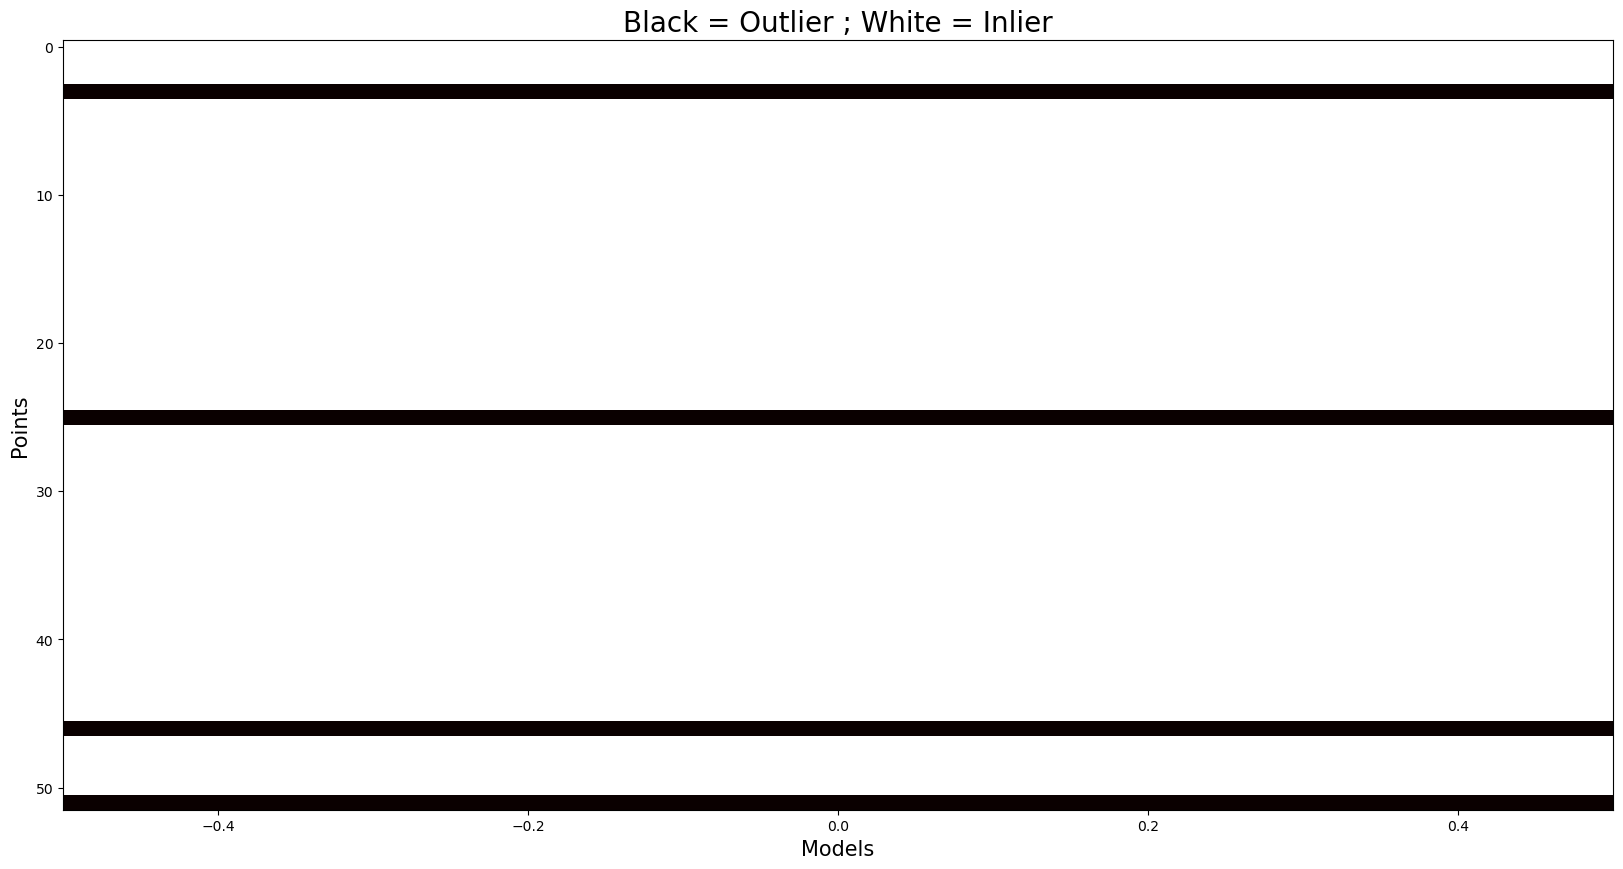

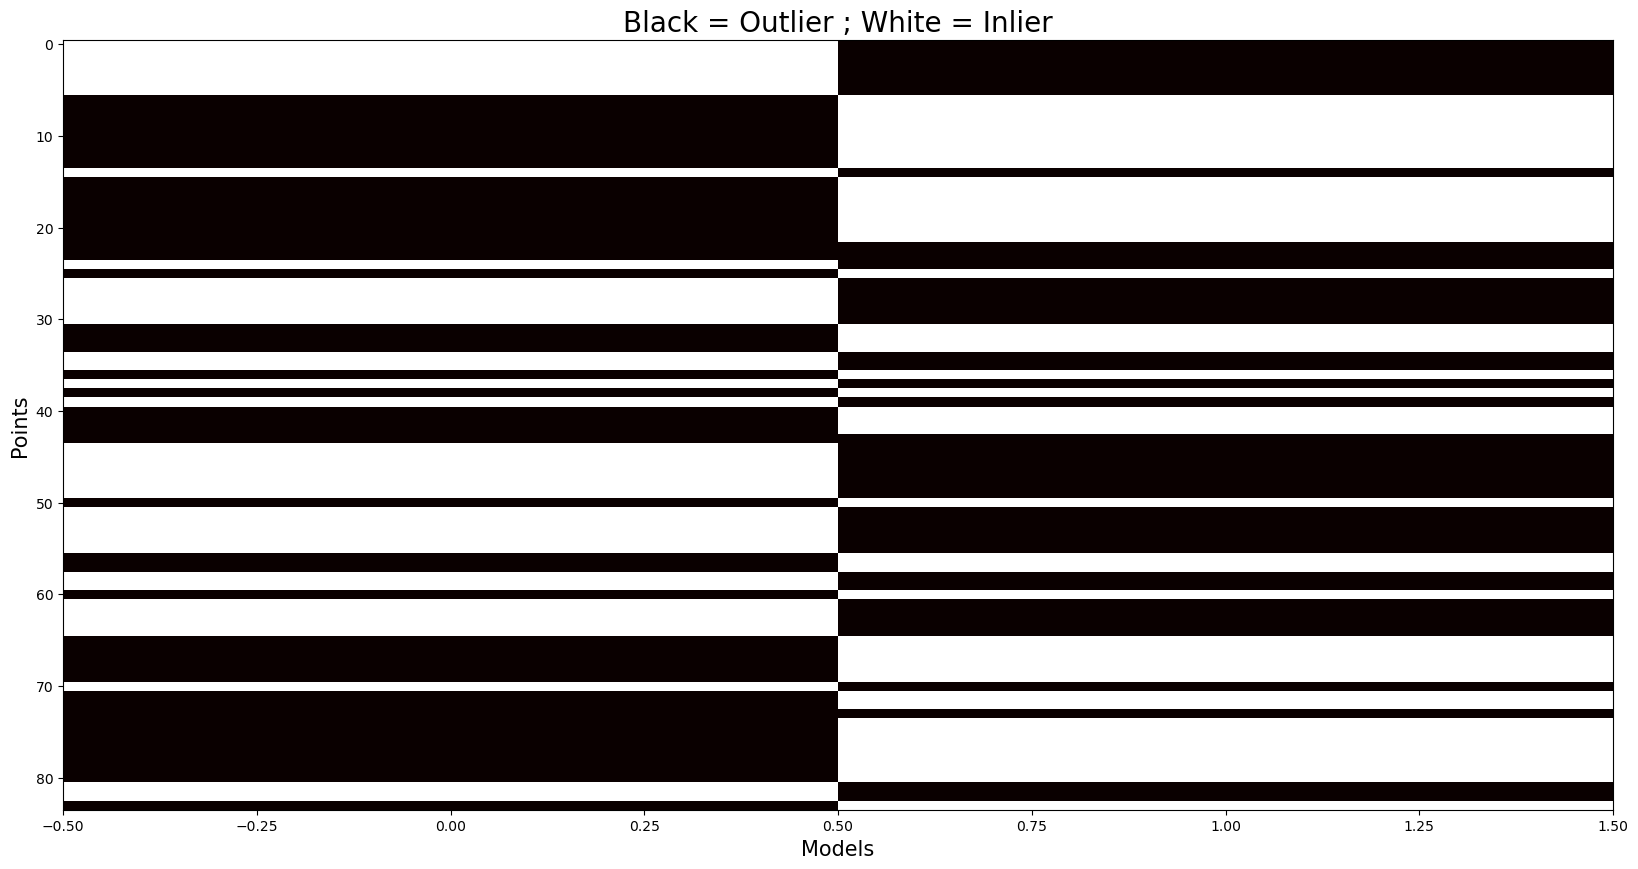

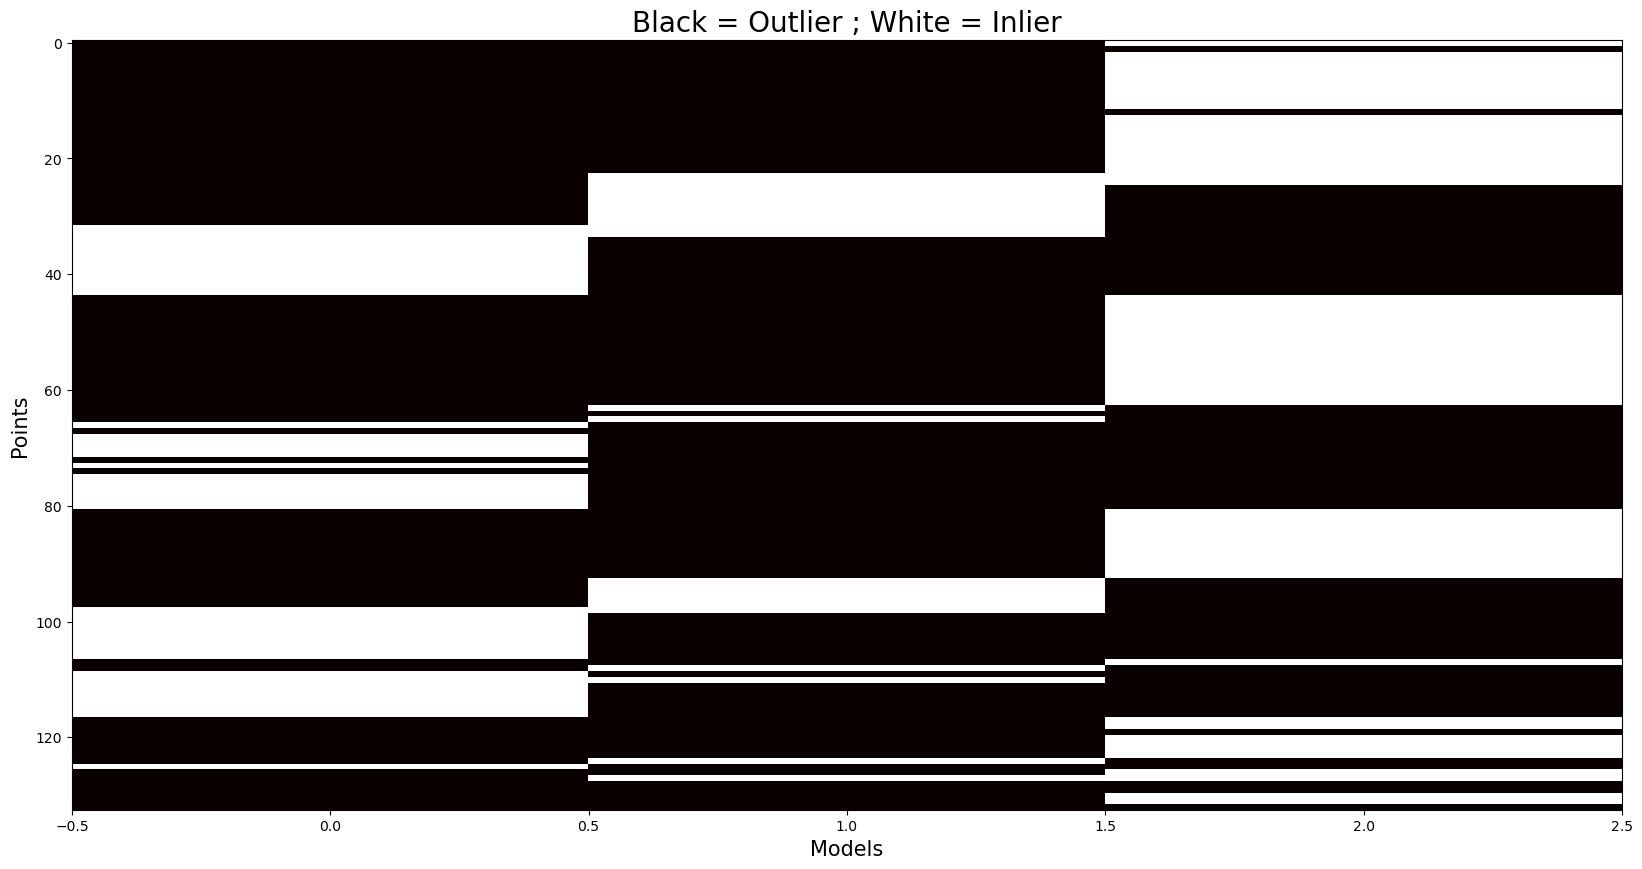

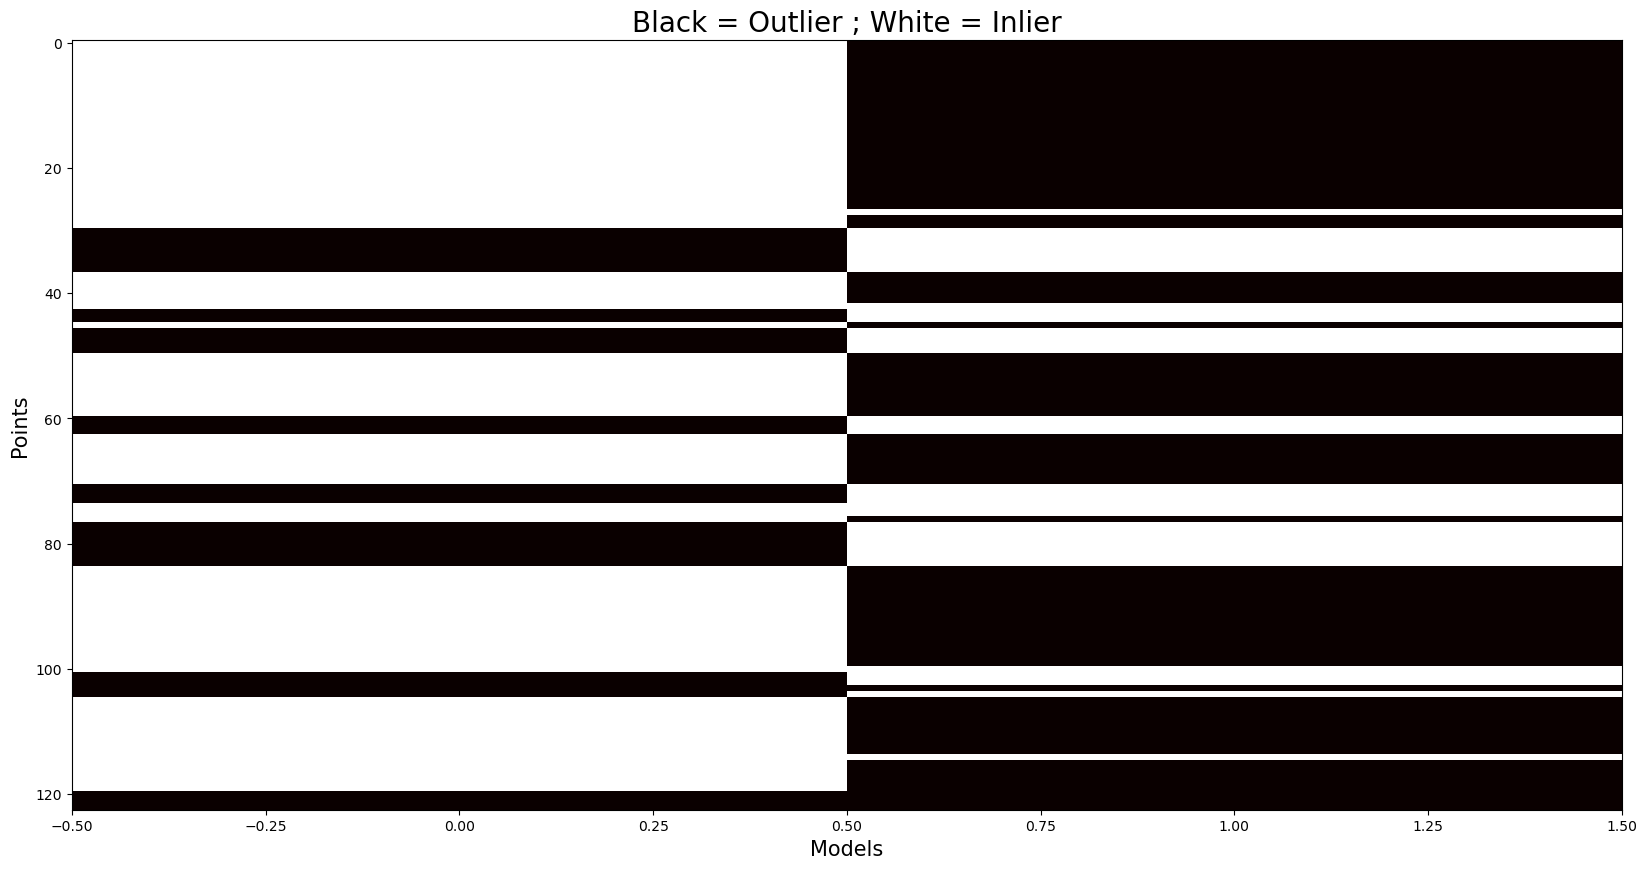

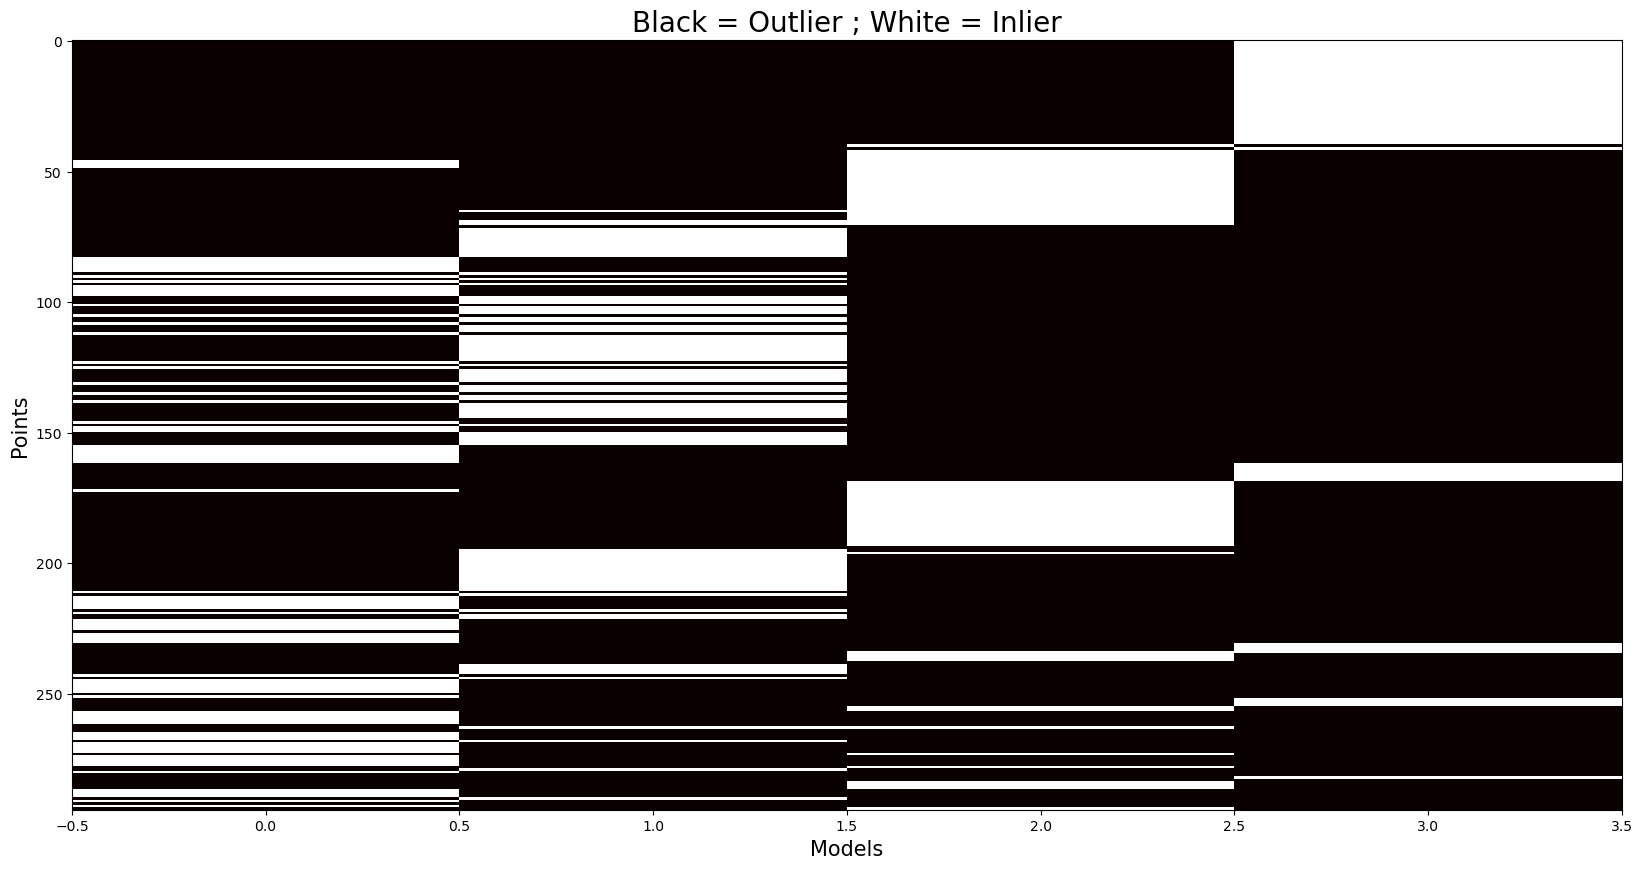

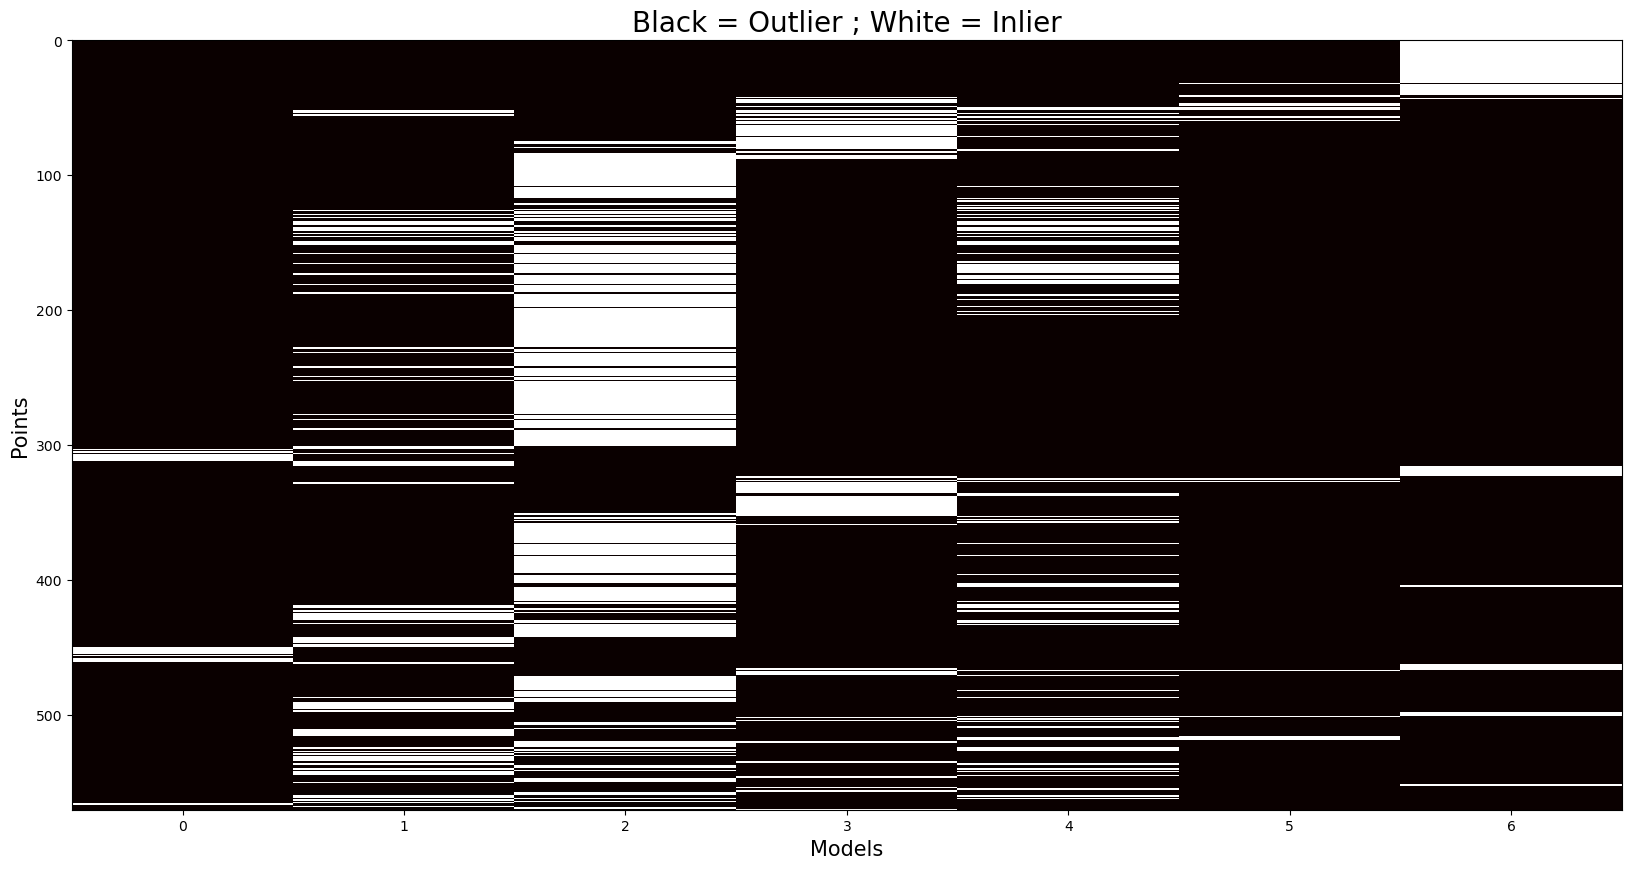

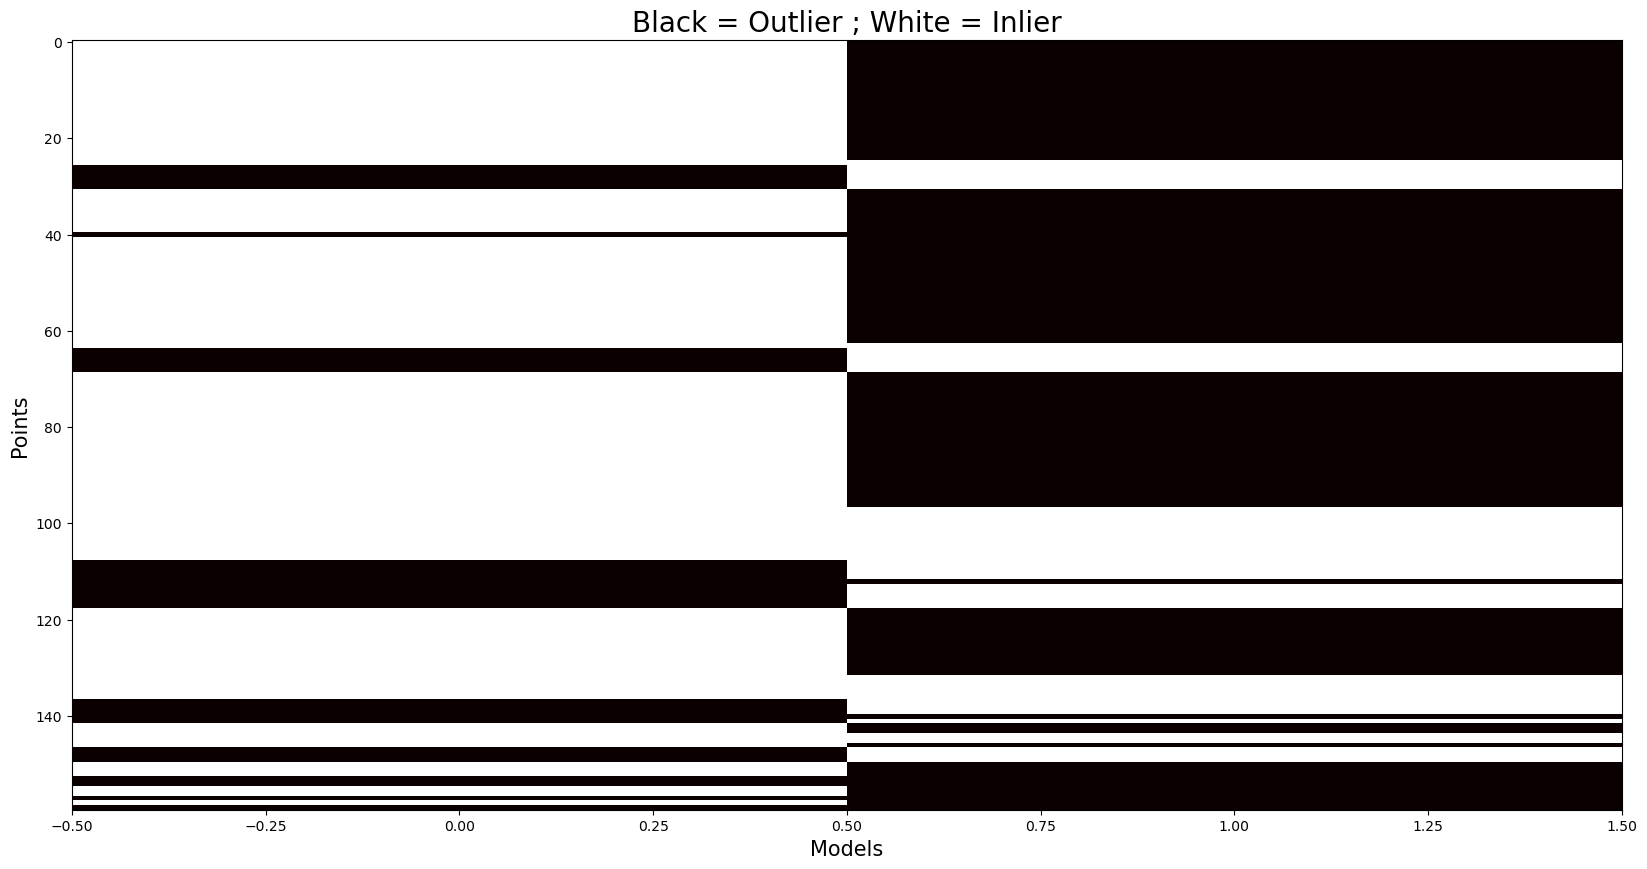

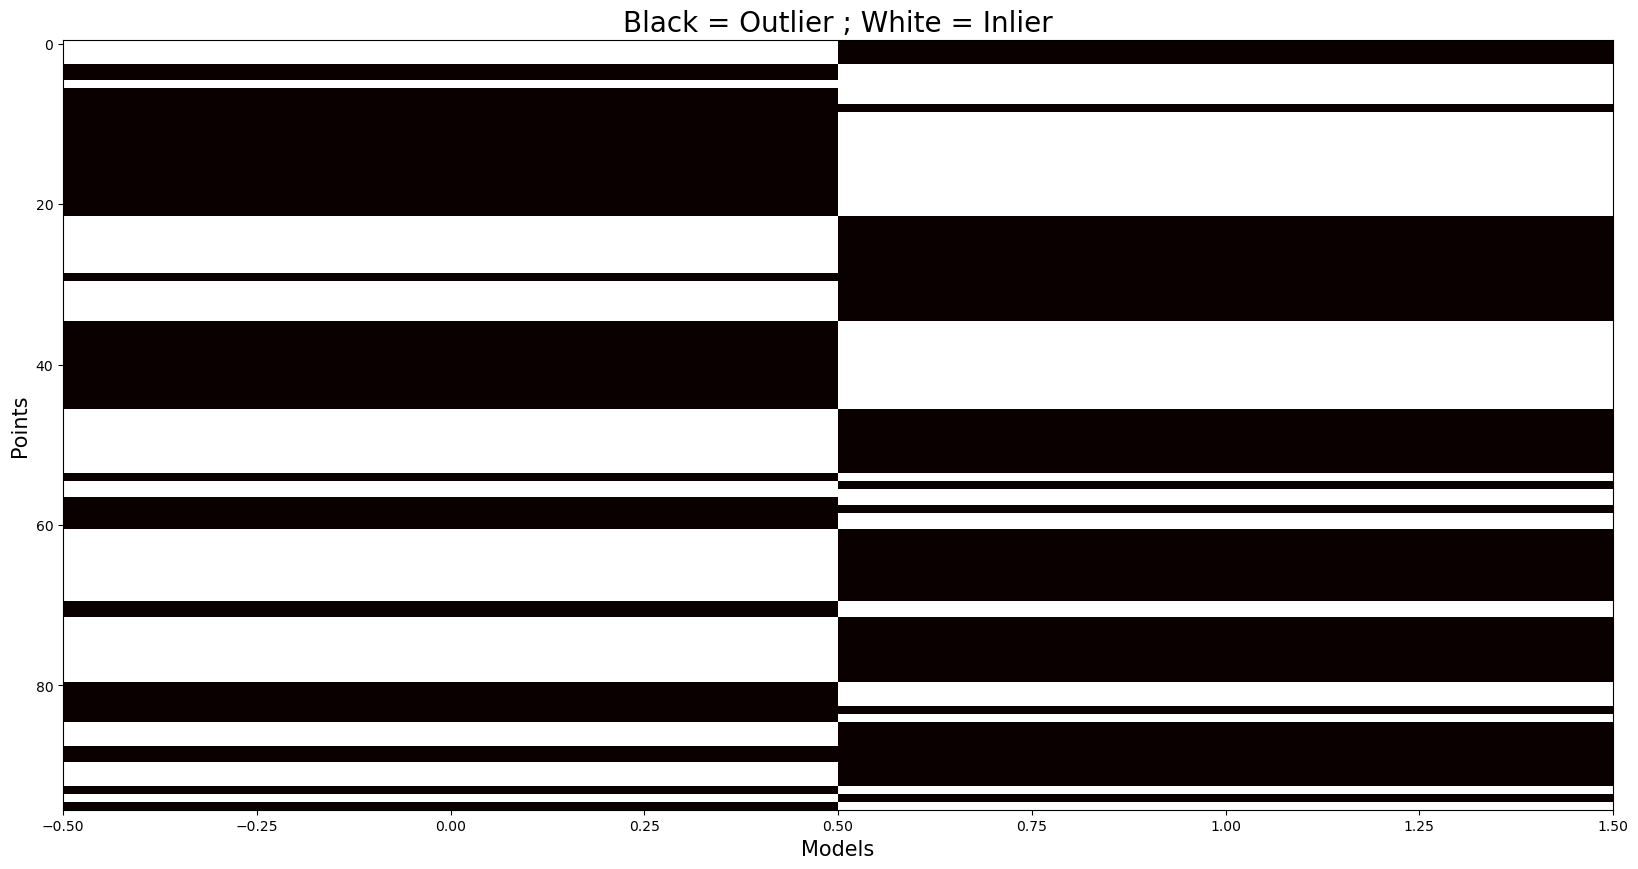

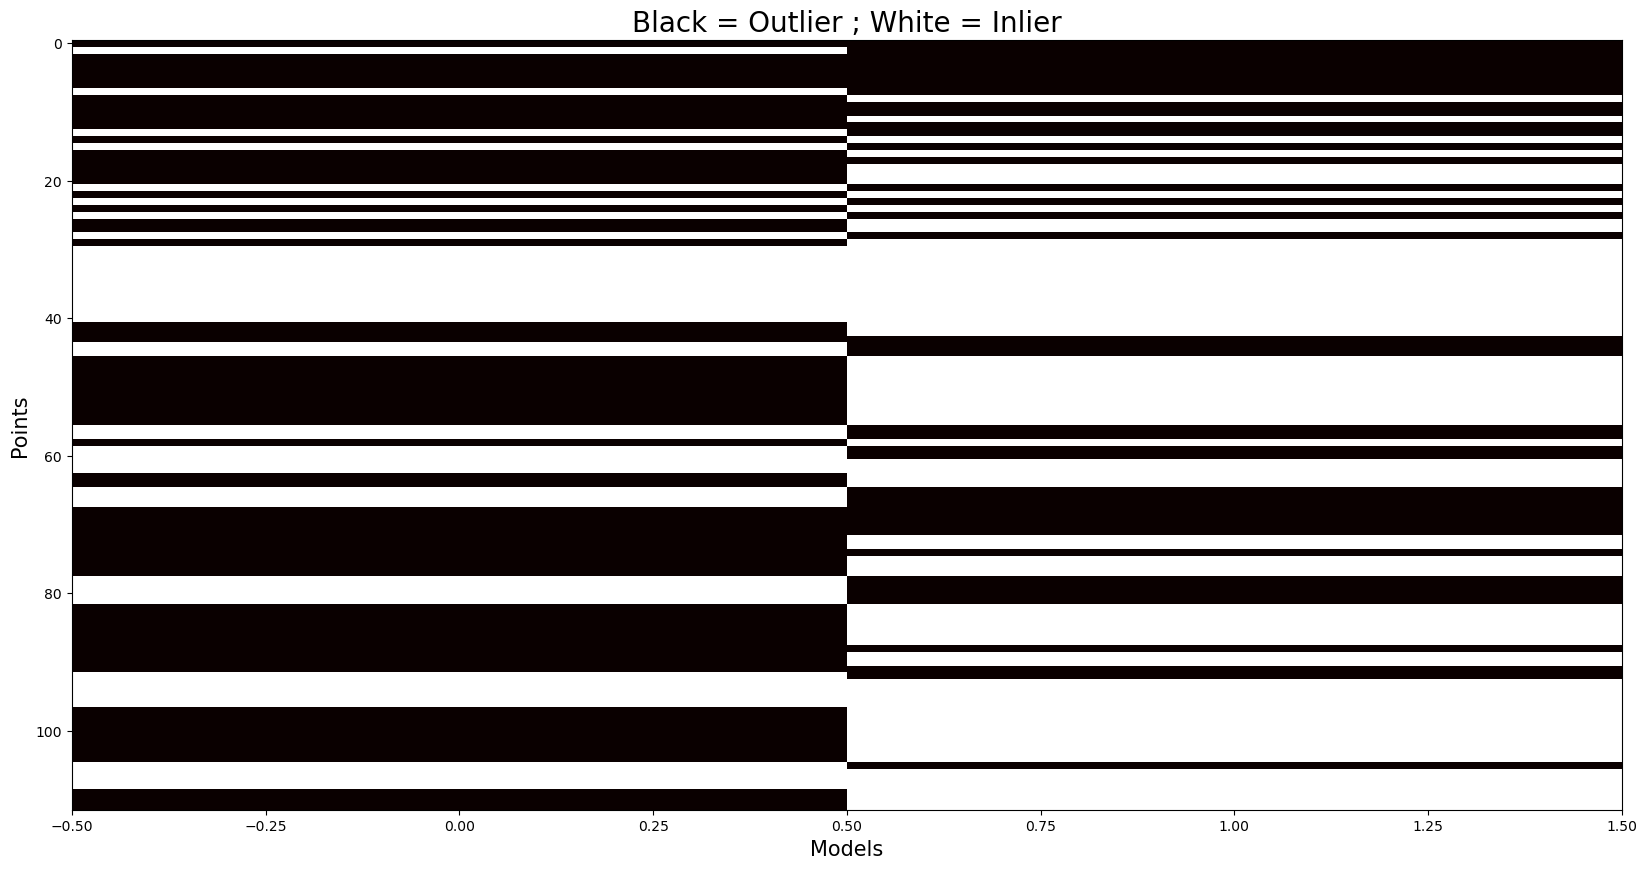

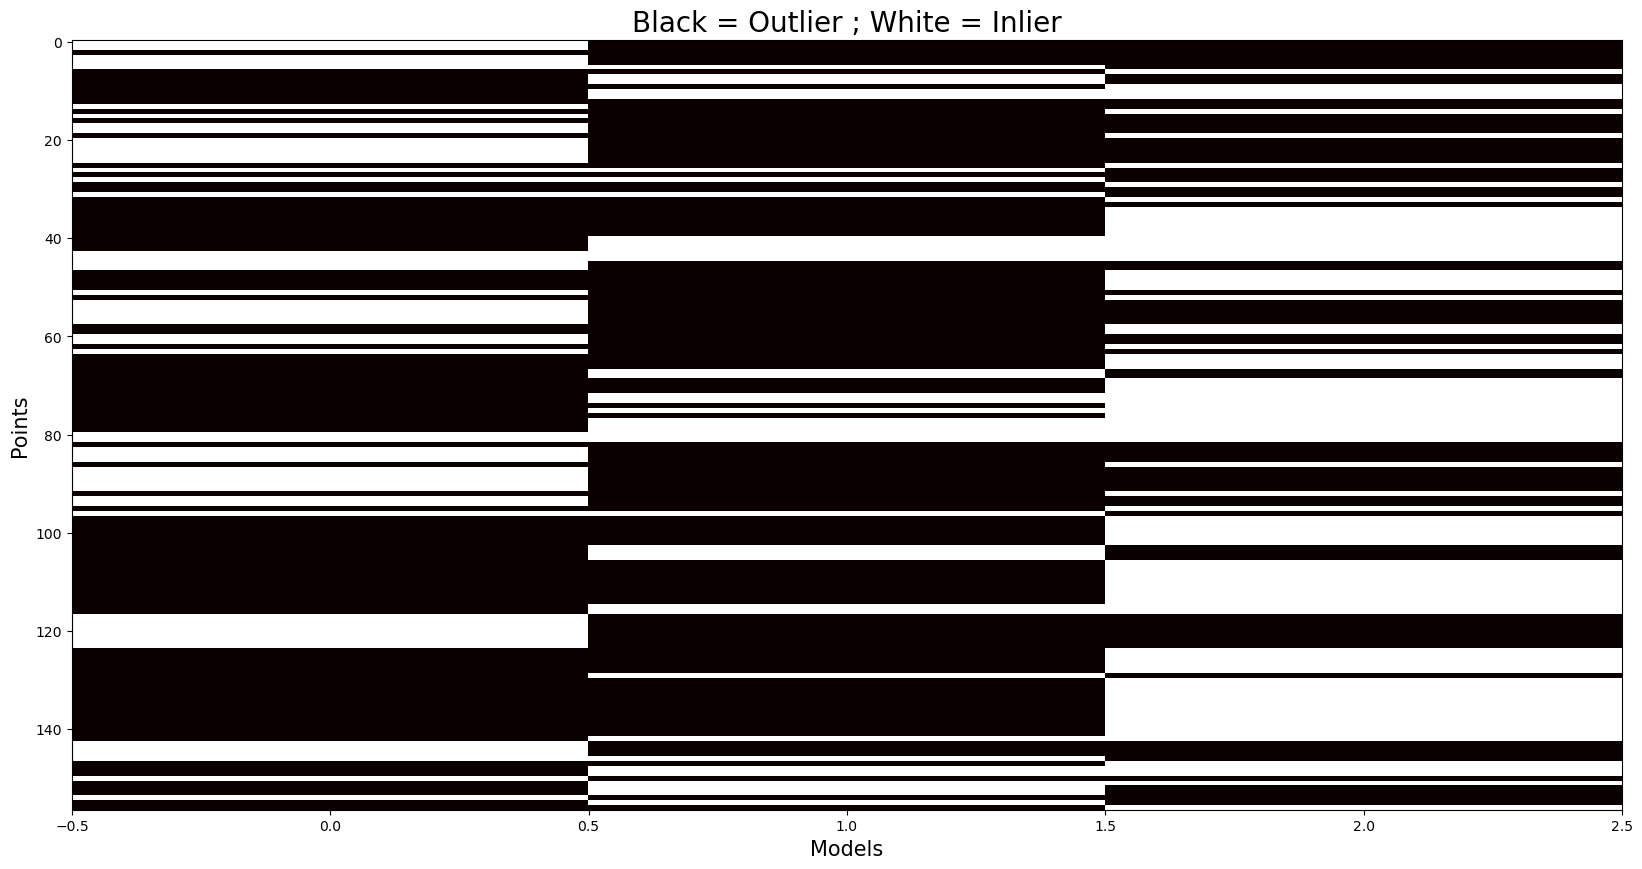

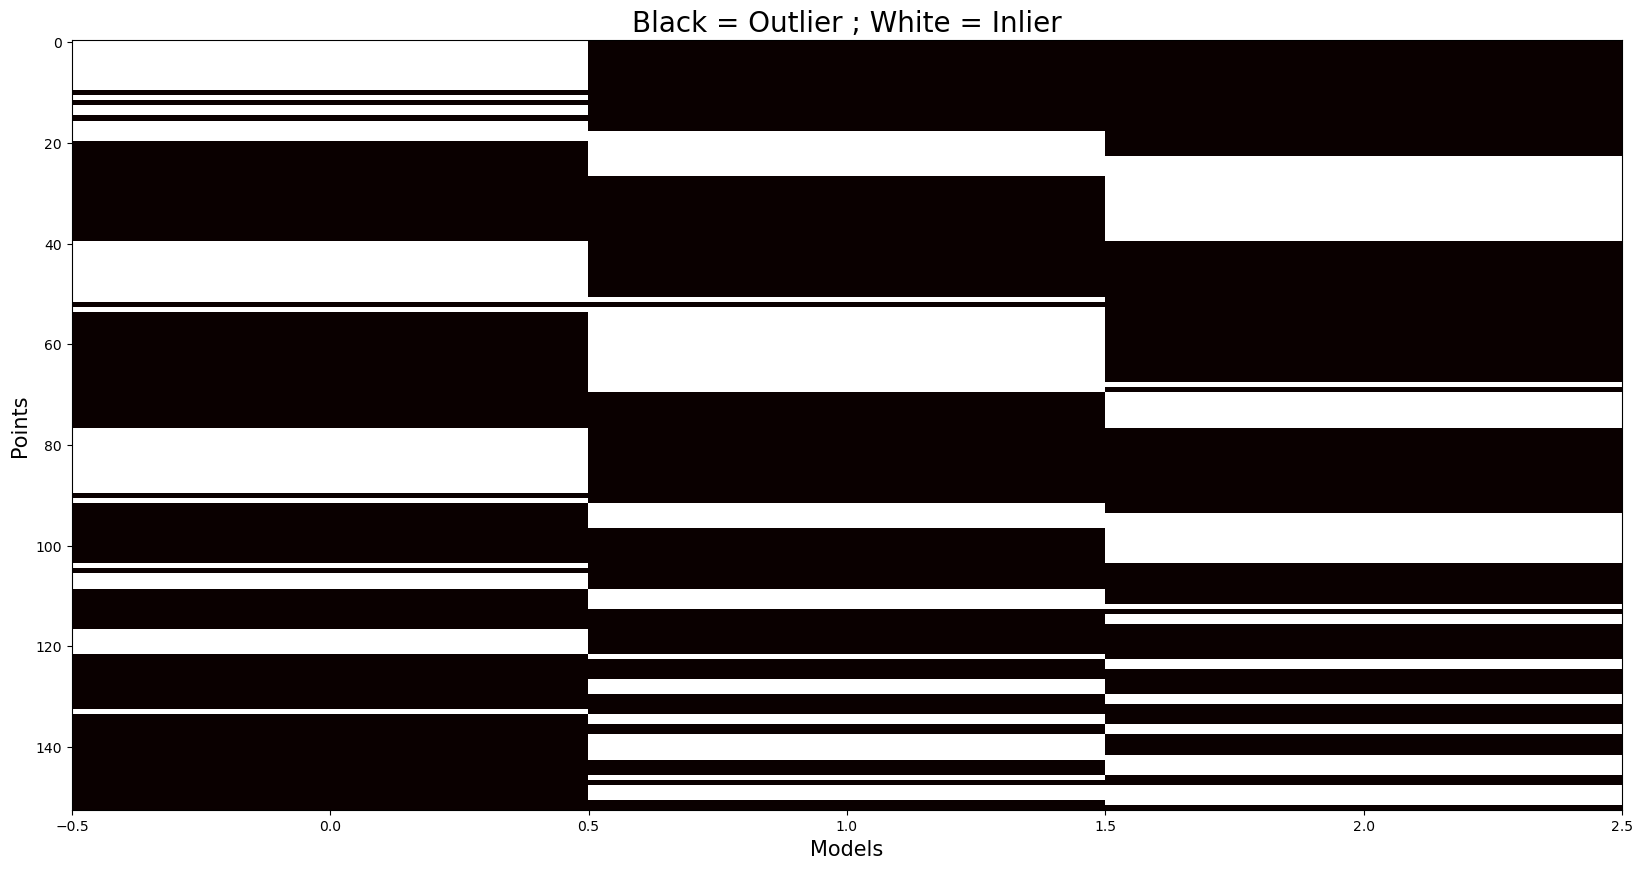

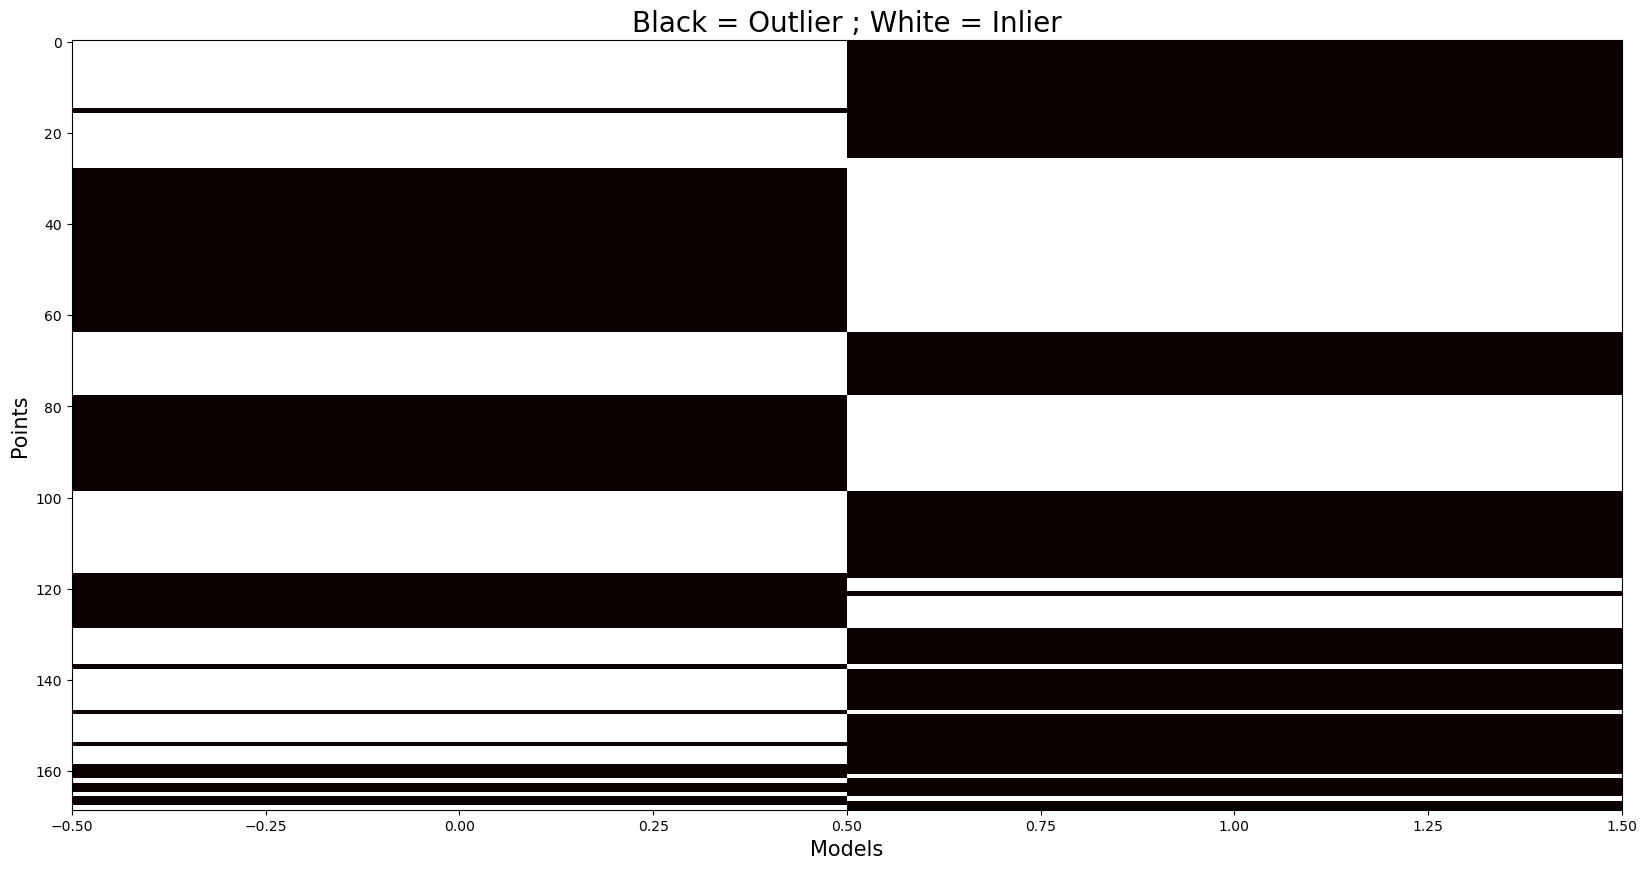

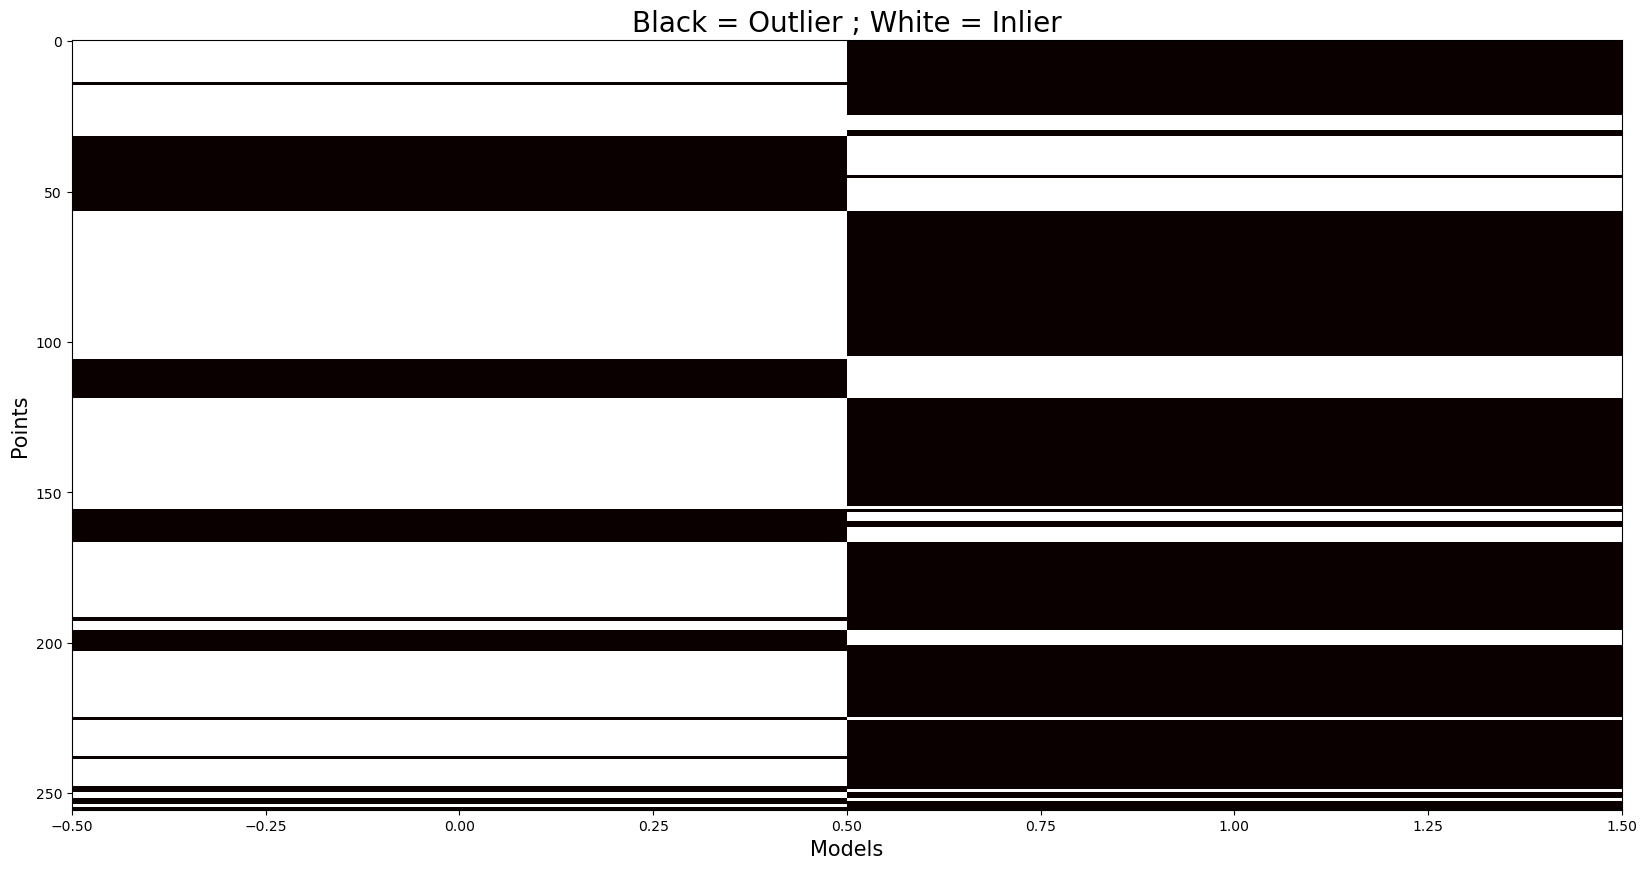

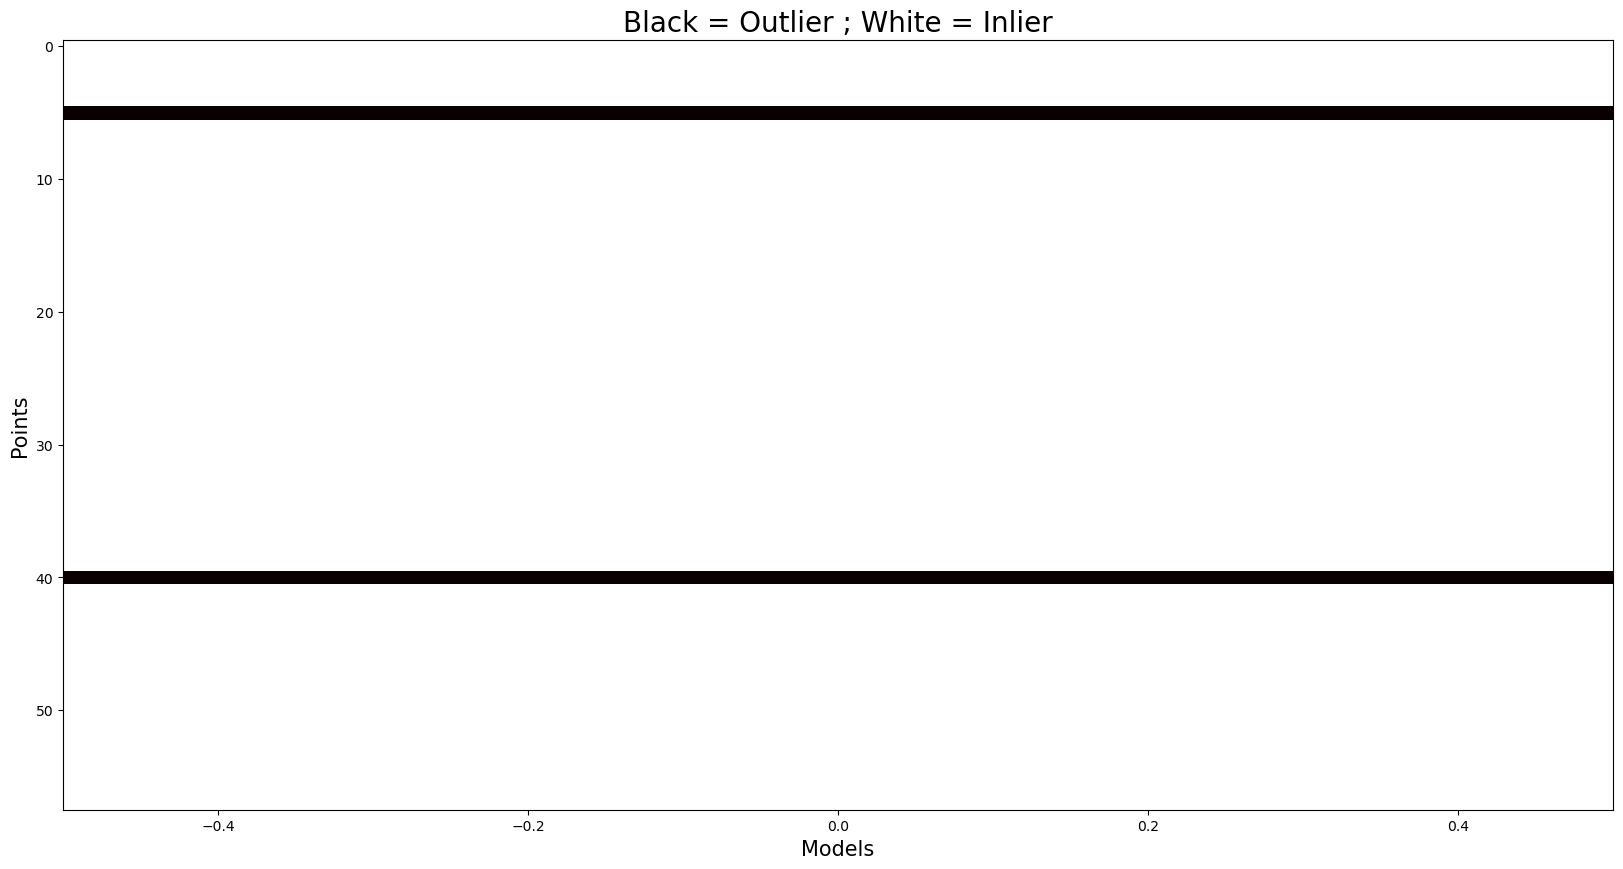

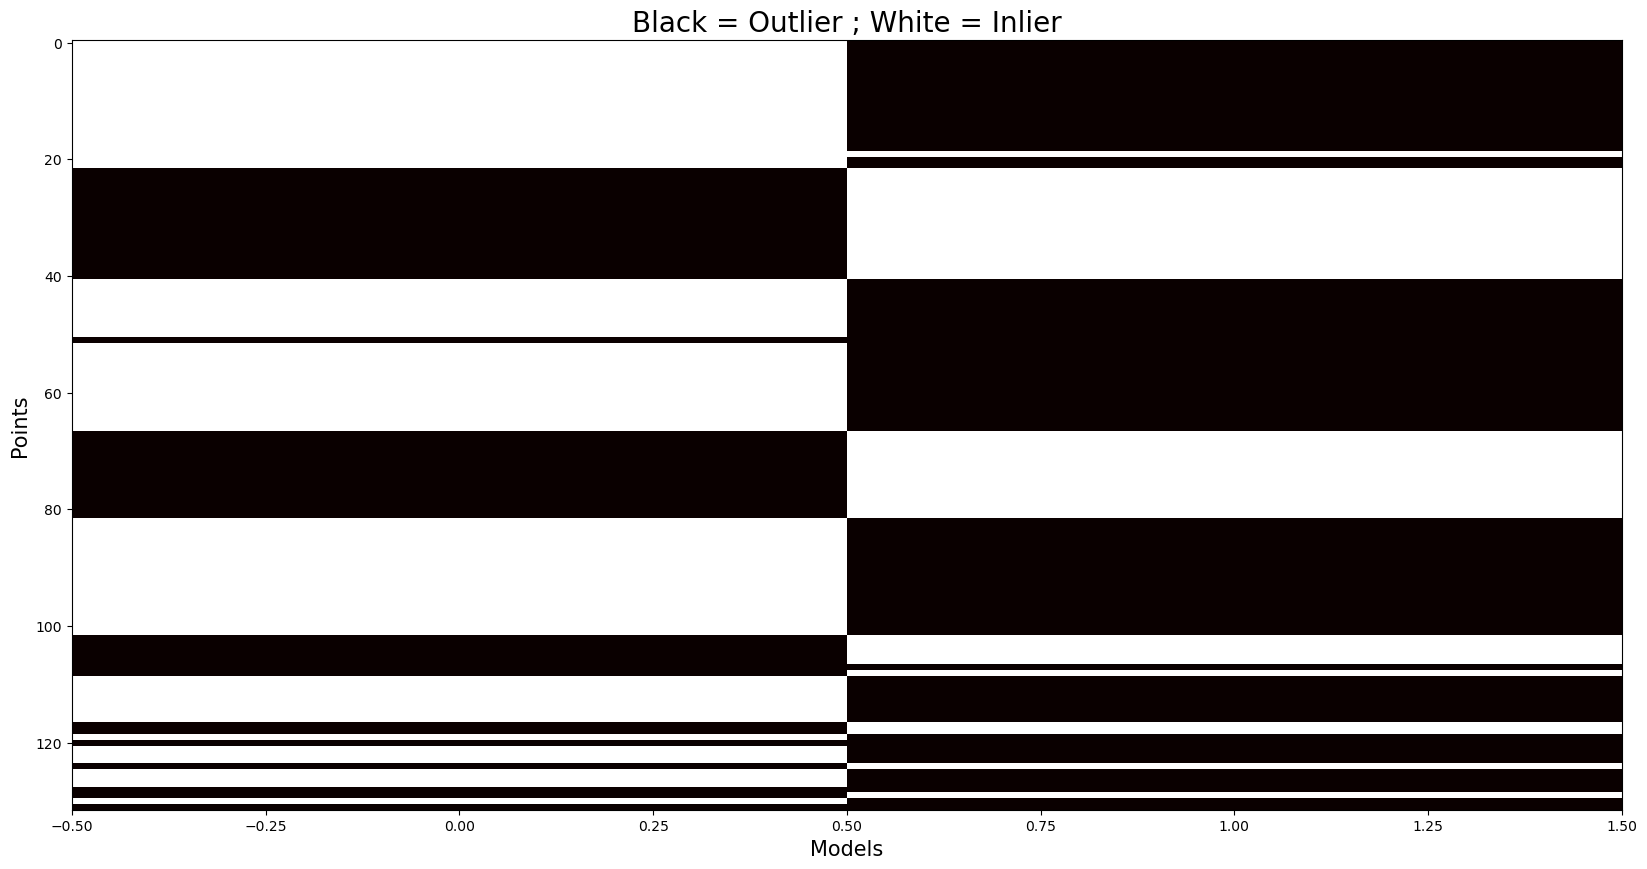

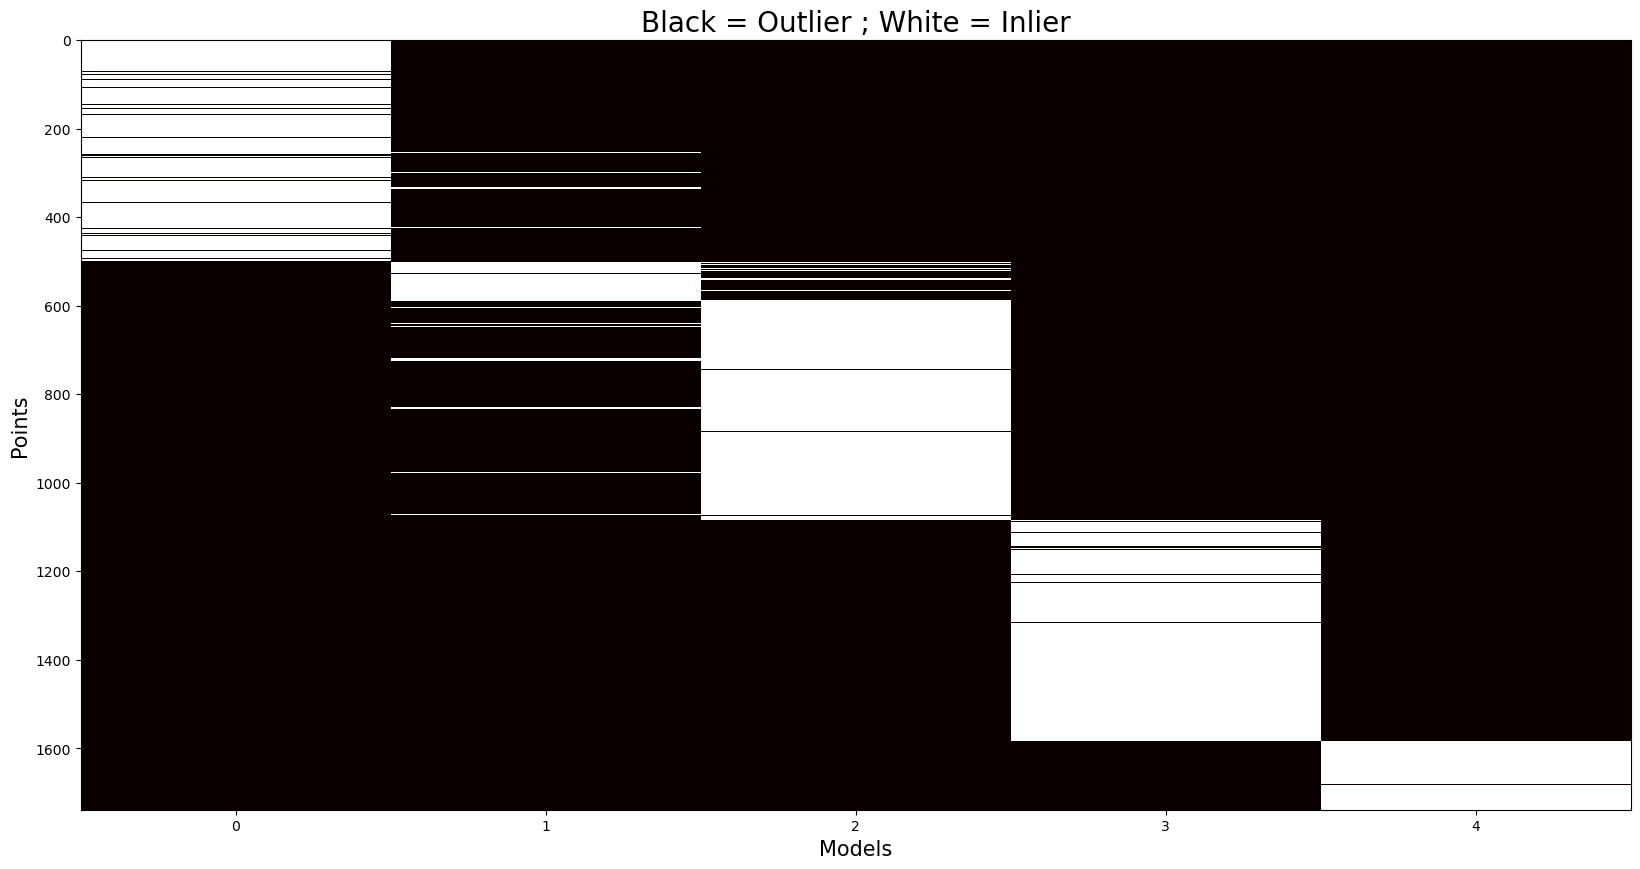

In [103]:
for i in range(number_of_data_to_analyse):
    data=mat_data[names[i]]
    
    res_matrix=build_residual_matrix(data,verbose=False)
    
    soft_clustering=soft_clustering_assignment(res_matrix,thresholds[i])

    plot_residual_matrix(soft_clustering,show_bar=False)
    

Several criteria for fuzzy clustering assessment have been proposed (e.g. see [23,12,21] and references therein).
Among the most widespread are the Fuzzy Hypervolume and Average Partition Density [19], the Xie–Beni index [38],
the Average Within-Cluster Distance [31], and the Average Silhouette Width Criterion [28,14

In [104]:
def residual_H1_wrt_H2(src,H1,H2):
    dst1=projectiveTransform(src, H1)
    dst2=projectiveTransform(src, H2)
    
    dst1 = dst1.reshape(src.shape[0], 2)
    dst2 = dst2.reshape(src.shape[0], 2)
    
    residuals = (np.sum((dst1 - dst2) ** 2, axis=1)) ** 0.5

    return residuals
    
    